In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/Shareddrives/AI201 Mini Project - Redondo')
os.getcwd()

'/content/drive/Shareddrives/AI201 Mini Project - Redondo'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [ ]:
application_train = pd.read_csv('application_train.csv')
application_test = pd.read_csv('application_test.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')
installments_payments = pd.read_csv('installments_payments.csv')
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
previous_application = pd.read_csv('previous_application.csv')
bureau = bureau.merge(bureau_balance, on='SK_ID_BUREAU', how='left')

## Preprocessing

The ff tables were aggregated by SK_ID_CURR so we can join it to the main application train dataframe:
- bureau
- bureau balance
- credit card balance
- installment payments
- POS Cash balance
- previous applications

In [ ]:
b_pivot = bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['min', 'max', 'mean', 'std'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT': ['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum', 'mean'],
    'AMT_CREDIT_SUM': ['sum', 'mean', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['sum', 'mean'],
    'AMT_CREDIT_SUM_LIMIT': ['sum', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['sum', 'mean'],
    'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
    'AMT_ANNUITY': ['sum', 'mean'],
    'MONTHS_BALANCE': ['median']
})
# Flatten column names
b_pivot.columns = ['BUREAU_' + '_'.join(col).upper() for col in b_pivot.columns]
b_pivot.reset_index(inplace=True)

In [ ]:
cat_cols = ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
bureau_cat = pd.get_dummies(bureau[cat_cols + ['SK_ID_CURR']], columns=cat_cols)

# Aggregate by SK_ID_CURR
cat_pivot = bureau_cat.groupby('SK_ID_CURR').agg('mean')  # or 'sum' for total count of occurrences
cat_pivot.columns = ['BUREAU_' + col.upper() for col in cat_pivot.columns]
cat_pivot.reset_index(inplace=True)

In [ ]:
bcat_pivot = b_pivot.merge(cat_pivot, on='SK_ID_CURR', how='left')
print(bcat_pivot[bcat_pivot['SK_ID_CURR'].duplicated()])

Empty DataFrame
Columns: [SK_ID_CURR, BUREAU_DAYS_CREDIT_MIN, BUREAU_DAYS_CREDIT_MAX, BUREAU_DAYS_CREDIT_MEAN, BUREAU_DAYS_CREDIT_STD, BUREAU_CREDIT_DAY_OVERDUE_MAX, BUREAU_CREDIT_DAY_OVERDUE_MEAN, BUREAU_DAYS_CREDIT_ENDDATE_MIN, BUREAU_DAYS_CREDIT_ENDDATE_MAX, BUREAU_DAYS_CREDIT_ENDDATE_MEAN, BUREAU_DAYS_ENDDATE_FACT_MIN, BUREAU_DAYS_ENDDATE_FACT_MAX, BUREAU_DAYS_ENDDATE_FACT_MEAN, BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX, BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN, BUREAU_CNT_CREDIT_PROLONG_SUM, BUREAU_CNT_CREDIT_PROLONG_MEAN, BUREAU_AMT_CREDIT_SUM_SUM, BUREAU_AMT_CREDIT_SUM_MEAN, BUREAU_AMT_CREDIT_SUM_MAX, BUREAU_AMT_CREDIT_SUM_DEBT_SUM, BUREAU_AMT_CREDIT_SUM_DEBT_MEAN, BUREAU_AMT_CREDIT_SUM_LIMIT_SUM, BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN, BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM, BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN, BUREAU_DAYS_CREDIT_UPDATE_MIN, BUREAU_DAYS_CREDIT_UPDATE_MAX, BUREAU_DAYS_CREDIT_UPDATE_MEAN, BUREAU_AMT_ANNUITY_SUM, BUREAU_AMT_ANNUITY_MEAN, BUREAU_MONTHS_BALANCE_MEDIAN, BUREAU_CREDIT_ACTIVE_A

In [ ]:
bb_pivot = pd.pivot_table(
    bureau_balance,
    values='MONTHS_BALANCE',
    index='SK_ID_BUREAU',
    aggfunc='median'
)

bb_pivot = bb_pivot.reset_index()
print(bb_pivot[bb_pivot['SK_ID_BUREAU'].duplicated()])

Empty DataFrame
Columns: [SK_ID_BUREAU, MONTHS_BALANCE]
Index: []


In [ ]:
cc_pivot = pd.pivot_table(
    credit_card_balance,
    values=['MONTHS_BALANCE','AMT_BALANCE'],
    index=['SK_ID_CURR'],
    aggfunc=['median','sum']
)

cc_pivot = cc_pivot.reset_index()

cc_pivot.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in cc_pivot.columns]
print(cc_pivot[cc_pivot['SK_ID_CURR_'].duplicated()])

Empty DataFrame
Columns: [SK_ID_CURR_, median_AMT_BALANCE, median_MONTHS_BALANCE, sum_AMT_BALANCE, sum_MONTHS_BALANCE]
Index: []


In [ ]:
installments_payments2 = installments_payments.copy(deep=True)

installments_payments2['PAID_COMPLETE'] = (
    (installments_payments2['AMT_PAYMENT'].fillna(0) >= installments_payments2['AMT_INSTALMENT'].fillna(0) * 0.9)
    .replace({True: 1, False: -1})
)

installments_payments2['PAID_ONTIME'] = (
    (installments_payments2['DAYS_ENTRY_PAYMENT'].fillna(0) <= installments_payments2['DAYS_INSTALMENT'].fillna(0))
).astype(int)

installments_payments2['PAID_ONTIME_WEIGHTED'] = (
    abs(installments_payments2['PAID_ONTIME'].fillna(0) / installments_payments2['DAYS_INSTALMENT'].fillna(0.01))
).astype(float)

installments_payments2['PAID_COMPLETE_WEIGHTED'] = (
    installments_payments2['AMT_PAYMENT'].fillna(0) * installments_payments2['PAID_COMPLETE']
).astype(float)

<ipython-input-11-39d2460ef1c7>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({True: 1, False: -1})


In [ ]:
ip_pivot = pd.pivot_table(
    installments_payments2,
    values=['PAID_ONTIME_WEIGHTED','PAID_COMPLETE_WEIGHTED'],
    index=['SK_ID_CURR'],
    aggfunc=['sum']
)

ip_pivot = ip_pivot.reset_index()

ip_pivot.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in ip_pivot.columns]
print(ip_pivot[ip_pivot['SK_ID_CURR_'].duplicated()])

Empty DataFrame
Columns: [SK_ID_CURR_, sum_PAID_COMPLETE_WEIGHTED, sum_PAID_ONTIME_WEIGHTED]
Index: []


In [ ]:
pa1_pivot = pd.pivot_table(
    POS_CASH_balance,
    values=['SK_DPD','SK_DPD_DEF'],
    index=['SK_ID_CURR'],
    aggfunc=['sum']
)

pa1_pivot = pa1_pivot.reset_index()

pa1_pivot.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pa1_pivot.columns]
print(pa1_pivot[pa1_pivot['SK_ID_CURR_'].duplicated()])

Empty DataFrame
Columns: [SK_ID_CURR_, sum_SK_DPD, sum_SK_DPD_DEF]
Index: []


In [ ]:
pa2_pivot = pd.pivot_table(
    POS_CASH_balance,
    index=['SK_ID_CURR'],
    columns=['NAME_CONTRACT_STATUS'],
    aggfunc='count'  # or mean, count, etc.
)

pa2_pivot = pa2_pivot.reset_index()

pa2_pivot.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pa2_pivot.columns]
pa2_pivot = pa2_pivot[['SK_ID_CURR_','SK_ID_PREV_Active', 'SK_ID_PREV_Amortized debt', 'SK_ID_PREV_Approved',
                       'SK_ID_PREV_Canceled', 'SK_ID_PREV_Completed', 'SK_ID_PREV_Demand',
                       'SK_ID_PREV_Returned to the store', 'SK_ID_PREV_Signed', 'SK_ID_PREV_XNA']].fillna(0)
print(pa2_pivot[pa2_pivot['SK_ID_CURR_'].duplicated()])

Empty DataFrame
Columns: [SK_ID_CURR_, SK_ID_PREV_Active, SK_ID_PREV_Amortized debt, SK_ID_PREV_Approved, SK_ID_PREV_Canceled, SK_ID_PREV_Completed, SK_ID_PREV_Demand, SK_ID_PREV_Returned to the store, SK_ID_PREV_Signed, SK_ID_PREV_XNA]
Index: []


In [ ]:
# Load previous application data
previous_df = pd.read_csv('previous_application.csv')

# Fill missing values in key numeric columns
previous_df['AMT_APPLICATION'] = previous_df['AMT_APPLICATION'].fillna(0)
previous_df['AMT_CREDIT'] = previous_df['AMT_CREDIT'].fillna(0)

# Create ratio features
previous_df['APP_CREDIT_RATIO'] = previous_df['AMT_APPLICATION'] / previous_df['AMT_CREDIT']
previous_df['APP_CREDIT_RATIO'] = previous_df['APP_CREDIT_RATIO'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Create boolean for approved and refused applications
previous_df['IS_APPROVED'] = (previous_df['NAME_CONTRACT_STATUS'] == 'Approved').astype(int)
previous_df['IS_REFUSED'] = (previous_df['NAME_CONTRACT_STATUS'] == 'Refused').astype(int)

# Group by SK_ID_CURR to create features
prev_pivot = previous_df.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV': 'count',  # Number of previous applications
    'IS_APPROVED': 'mean',
    'IS_REFUSED': 'mean',
    'AMT_APPLICATION': ['mean', 'max', 'min'],
    'AMT_CREDIT': ['mean', 'max', 'min'],
    'APP_CREDIT_RATIO': ['mean', 'std'],
    'CNT_PAYMENT': ['mean', 'std'],
    'DAYS_DECISION': ['min', 'max'],
    'DAYS_TERMINATION': ['mean'],
    'DAYS_LAST_DUE': ['mean'],
    'DAYS_FIRST_DRAWING': ['mean']
})

# Flatten MultiIndex columns
prev_pivot.columns = ['PREV_' + '_'.join(col).upper() for col in prev_pivot.columns]

# Reset index to make SK_ID_CURR a column
prev_pivot = prev_pivot.reset_index()
print(prev_pivot[prev_pivot['SK_ID_CURR'].duplicated()])

Empty DataFrame
Columns: [SK_ID_CURR, PREV_SK_ID_PREV_COUNT, PREV_IS_APPROVED_MEAN, PREV_IS_REFUSED_MEAN, PREV_AMT_APPLICATION_MEAN, PREV_AMT_APPLICATION_MAX, PREV_AMT_APPLICATION_MIN, PREV_AMT_CREDIT_MEAN, PREV_AMT_CREDIT_MAX, PREV_AMT_CREDIT_MIN, PREV_APP_CREDIT_RATIO_MEAN, PREV_APP_CREDIT_RATIO_STD, PREV_CNT_PAYMENT_MEAN, PREV_CNT_PAYMENT_STD, PREV_DAYS_DECISION_MIN, PREV_DAYS_DECISION_MAX, PREV_DAYS_TERMINATION_MEAN, PREV_DAYS_LAST_DUE_MEAN, PREV_DAYS_FIRST_DRAWING_MEAN]
Index: []


In [ ]:
# JOINING WITH MAIN DATAFRAME
cc_pivot.rename(columns={'SK_ID_CURR_': 'SK_ID_CURR'}, inplace=True)
ip_pivot.rename(columns={'SK_ID_CURR_': 'SK_ID_CURR'}, inplace=True)
pa1_pivot.rename(columns={'SK_ID_CURR_': 'SK_ID_CURR'}, inplace=True)
pa2_pivot.rename(columns={'SK_ID_CURR_': 'SK_ID_CURR'}, inplace=True)
prev_pivot.rename(columns={'SK_ID_CURR_': 'SK_ID_CURR'}, inplace=True)
bb_pivot.rename(columns={'SK_ID_BUREAU': 'SK_ID_CURR'}, inplace=True)  # Assuming aggregation done at SK_ID_CURR

# Merge all datasets on SK_ID_CURR
application_full = application_train.copy(deep=True)
application_full = application_full.merge(bcat_pivot, on='SK_ID_CURR', how='left')
application_full = application_full.merge(bb_pivot, on='SK_ID_CURR', how='left')
application_full = application_full.merge(cc_pivot, on='SK_ID_CURR', how='left')
application_full = application_full.merge(ip_pivot, on='SK_ID_CURR', how='left')
application_full = application_full.merge(pa1_pivot, on='SK_ID_CURR', how='left')
application_full = application_full.merge(pa2_pivot, on='SK_ID_CURR', how='left')
application_full = application_full.merge(prev_pivot, on='SK_ID_CURR', how='left')

In [ ]:
# Merge all datasets on SK_ID_CURR
application_full_test = application_test.copy(deep=True)
application_full_test = application_full_test.merge(bcat_pivot, on='SK_ID_CURR', how='left')
application_full_test = application_full_test.merge(bb_pivot, on='SK_ID_CURR', how='left')
application_full_test = application_full_test.merge(cc_pivot, on='SK_ID_CURR', how='left')
application_full_test = application_full_test.merge(ip_pivot, on='SK_ID_CURR', how='left')
application_full_test = application_full_test.merge(pa1_pivot, on='SK_ID_CURR', how='left')
application_full_test = application_full_test.merge(pa2_pivot, on='SK_ID_CURR', how='left')
application_full_test = application_full_test.merge(prev_pivot, on='SK_ID_CURR', how='left')

In [ ]:
application_full = application_full.set_index('SK_ID_CURR').apply(lambda col: col.astype('object') if col.dtype == 'category' else col)
application_full_test = application_full_test.set_index('SK_ID_CURR').apply(lambda col: col.astype('object') if col.dtype == 'category' else col)

In [ ]:
application_categorized2 = application_full.copy()
application_categorized2_test = application_full_test.copy()

In [ ]:
a=list(application_full.columns)
b=list(application_full_test.columns)
print([item for item in a if item not in b])
print([item for item in b if item not in a])

['TARGET']
[]


In [ ]:
binary_columns = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

for col in binary_columns:
    application_categorized2.loc[:,col] = application_categorized2[col].map({'Y': 1, 'N': 0})
    application_categorized2_test.loc[:,col] = application_categorized2_test[col].map({'Y': 1, 'N': 0})

In [ ]:
a=list(application_categorized2.columns)
b=list(application_categorized2_test.columns)
print([item for item in a if item not in b])
print([item for item in b if item not in a])

['TARGET']
[]


In [ ]:
education_order = {
    'Higher education ': 3,
    'Incomplete higher': 2,
    'Secondary / secondary special': 1,
    'Lower secondary ': 0
}

occupation_order = {
    'Low-skill Laborers': 0,
    'Cleaning staff': 1,
    'Waiters/barmen staff': 2,
    'Cooking staff': 3,
    'Private service staff': 4,
    'Laborers': 5,
    'Security staff': 6,
    'Drivers': 7,
    'Sales staff': 8,
    'Secretaries': 9,
    'Core staff': 10,
    'HR staff': 11,
    'Realty agents': 12,
    'Accountants': 13,
    'IT staff': 14,
    'Medicine staff': 15,
    'High skill tech staff': 16,
    'Managers': 17
}

application_categorized2.loc[:,'NAME_EDUCATION_TYPE'] = application_categorized2['NAME_EDUCATION_TYPE'].map(education_order)
application_categorized2.loc[:,'OCCUPATION_TYPE'] = application_categorized2['OCCUPATION_TYPE'].map(occupation_order)
application_categorized2_test.loc[:,'NAME_EDUCATION_TYPE'] = application_categorized2_test['NAME_EDUCATION_TYPE'].map(education_order)
application_categorized2_test.loc[:,'OCCUPATION_TYPE'] = application_categorized2_test['OCCUPATION_TYPE'].map(occupation_order)

In [ ]:
a=list(application_categorized2.columns)
b=list(application_categorized2_test.columns)
print([item for item in a if item not in b])
print([item for item in b if item not in a])

['TARGET']
[]


In [ ]:
# Label encode high-cardinality columns
label_encode_columns = ['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

for col in label_encode_columns:
    if col in application_categorized2.columns:
        le = LabelEncoder()
        application_categorized2.loc[:,col] = le.fit_transform(application_categorized2[col].astype(str))
        application_categorized2_test.loc[:,col] = le.fit_transform(application_categorized2_test[col].astype(str))

In [ ]:
a=list(application_categorized2.columns)
b=list(application_categorized2_test.columns)
print([item for item in a if item not in b])
print([item for item in b if item not in a])

['TARGET']
[]


In [ ]:
one_hot_columns = [
    'NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'CREDIT_ACTIVE',
    'CREDIT_CURRENCY', 'CREDIT_TYPE'
]

application_categorized2 = pd.get_dummies(application_categorized2, drop_first=True)
application_categorized2_test = pd.get_dummies(application_categorized2_test, drop_first=True)

In [ ]:
a=list(application_categorized2.columns)
b=list(application_categorized2_test.columns)
print([item for item in a if item not in b])
print([item for item in b if item not in a])

['TARGET', 'CODE_GENDER_XNA', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_FAMILY_STATUS_Unknown']
[]


In [ ]:
application_categorized2=application_categorized2.drop(['CODE_GENDER_XNA', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_FAMILY_STATUS_Unknown'],axis=1)

In [ ]:
features = application_categorized2.drop(columns=['TARGET'], errors='ignore')
target = application_categorized2['TARGET']
target.value_counts()

,count
TARGET,
0,282686
1,24825


## Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(features, target)

## Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_array = scaler.fit_transform(X)

scaled_df = pd.DataFrame(scaled_array, columns=X.columns, index=X.index)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size=0.2, stratify=y)

# Initial Model Fit

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb


# Create model with native categorical support
model = xgb.XGBClassifier(
    tree_method='hist',
    eval_metric='logloss'
)

# Fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("ROC AUC:", roc_auc_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, zero_division=0))

ROC AUC: 0.6987915407854985
Accuracy: 0.6987915407854985
Precision: 0.7010183299389002
Recall: 0.6932527693856999
F1 Score: 0.6971139240506329


# Feature Selection

In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
print(len(X_train.columns))

313


In [ ]:
X_trainb = X_train.astype({col: 'int' for col in X_train.select_dtypes(bool).columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes(bool).columns})

import shap
explainer = shap.Explainer(model, X_trainb)
shap_values = explainer(X_trainb)

# Get mean absolute SHAP values per featureb
shap_importance = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.Series(shap_importance, index=X_trainb.columns).sort_values(ascending=False)

100%|===================| 39680/39720 [03:16<00:00]       

Drop Highly Correlated Features with Low Shap

In [ ]:
def drop_correlated_by_shap(df, shap_importance, threshold=0.9):

    corr_matrix = df.corr().abs()
    columns = set(df.columns)
    to_drop = set()

    # Work on a copy to avoid modifying original
    remaining = set(columns)

    while True:
        # Get correlated pairs above threshold
        correlated_pairs = [
            (i, j)
            for i in remaining
            for j in remaining
            if i != j and corr_matrix.loc[i, j] > threshold
        ]
        if not correlated_pairs:
            break

        # Group correlated features
        groups = []
        seen = set()
        for i, j in correlated_pairs:
            if i not in seen and j not in seen:
                group = {i, j}
                for a, b in correlated_pairs:
                    if a in group or b in group:
                        group.update([a, b])
                groups.append(group)
                seen.update(group)

        for group in groups:
            # From group, keep feature with highest SHAP importance
            sorted_group = sorted(
                group,
                key=lambda x: shap_importance.get(x, 0),
                reverse=True
            )
            keep = sorted_group[0]
            drop = group - {keep}
            to_drop.update(drop)
            remaining -= drop

        # Update remaining columns for next iteration
        remaining -= to_drop

    return list(columns - to_drop)

# Get final feature list
selected_features = drop_correlated_by_shap(X_trainb, feature_importance, threshold=0.9)

# Apply to data
X_train_reduced = X_trainb[selected_features]
X_test_reduced = X_test[selected_features]

# Model Fit to Assess Improvement After Feature Selection

In [ ]:
print(len(X_train_reduced.columns))

267


In [ ]:
# Create model with native categorical support
model = xgb.XGBClassifier(
    tree_method='hist',
    eval_metric='logloss'
)

# Fit the model
model.fit(X_train_reduced, y_train)
y_pred_reduced = model.predict(X_test_reduced)

print("ROC AUC:", roc_auc_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, zero_division=0))

ROC AUC: 0.6987915407854985
Accuracy: 0.6987915407854985
Precision: 0.7010183299389002
Recall: 0.6932527693856999
F1 Score: 0.6971139240506329


# XGBoost vs LightGBM

### For hyperparameter tuning
- Grid Search for XGBoost
- Optuna for LightGB

Model Fit using the best hyperparameters for XGBoost

In [ ]:
model = xgb.XGBClassifier(
    tree_method='hist',
    eval_metric='logloss',
    objective='binary:logistic',
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200
)

# Fit the model
model.fit(X_train_reduced, y_train)
y_pred_reduced = model.predict(X_test_reduced)

print("ROC AUC:", roc_auc_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, zero_division=0))

ROC AUC: 0.6987915407854985
Accuracy: 0.6987915407854985
Precision: 0.7010183299389002
Recall: 0.6932527693856999
F1 Score: 0.6971139240506329


Model Fit using best hyperparameter for LightGBM

In [ ]:
%%capture
# Train LightGBM
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=200,
    learning_rate=0.1,
    # max_depth=3,
    num_leaves=54,
    min_child_samples=83,
    class_weight='balanced',  # good for imbalanced data

    # Regularization
    lambda_l1=6.272660493727634,               # L1 regularization
    lambda_l2=0.005195334960259853,               # L2 regularization
    min_gain_to_split=0.1,      # Don't split unless gain > 0.1

    # Subsampling (stochastic training)
    feature_fraction=0.6194868591098514,        # Randomly use 80% of features per tree
    bagging_fraction=0.9038267401229967,        # Use 80% of data for each iteration
    bagging_freq=4
)

# Sanitize feature names to remove special characters
X_train_reduced1 = X_train_reduced.copy(deep=True)
X_test_reduced1 = X_test_reduced.copy(deep=True)
X_train_reduced1.columns = X_train_reduced.columns.str.replace(r'[^\w]', '_', regex=True)
X_test_reduced1.columns = X_test_reduced.columns.str.replace(r'[^\w]', '_', regex=True)
lgb_model.fit(X_train_reduced1, y_train)

# Step 7: Predictions and evaluation
y_pred = lgb_model.predict(X_test_reduced1)
y_proba = lgb_model.predict_proba(X_test_reduced1)[:, 1]

In [ ]:
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("F1 Score:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))

ROC AUC Score: 0.7792342571210964
F1 Score: 0.7087945260615818
Accuracy: 0.7085599194360523
Precision: 0.7082244118238488
Recall: 0.7093655589123867


# Fairness

### ROC AUC Per Gender
- False : Female
- True : Male

### Calculate Model Fairness

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

def fairness_fpr_gap(y_true, y_pred, sensitive_features):
    """
    Returns the FPR gap between sensitive groups (e.g., genders).

    Parameters:
        y_true: true labels (binary)
        y_pred: predicted labels (binary)
        sensitive_features: array-like, group labels (e.g., 'Male'/'Female')

    Returns:
        Dictionary with FPRs for each group and the FPR gap.
    """
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'group': sensitive_features
    })

    fprs = {}
    for group in df['group'].unique():
        group_df = df[df['group'] == group]
        tn, fp, fn, tp = confusion_matrix(group_df['y_true'], group_df['y_pred'], labels=[0, 1]).ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        fprs[group] = fpr

    groups = list(fprs.keys())
    fpr_gap = abs(fprs[groups[0]] - fprs[groups[1]]) if len(groups) == 2 else None

    return {
        'fpr_group_1': fprs[groups[0]],
        'fpr_group_2': fprs[groups[1]],
        'fpr_gap': fpr_gap
    }

In [ ]:
# Assuming binary predictions and gender labels
gender_test = X_test_reduced1["CODE_GENDER_M"]
fairness_result = fairness_fpr_gap(y_test, y_pred, gender_test)

print('fpr_gap:', fairness_result['fpr_gap'])
# Output: {'fpr_group_1': 0.38, 'fpr_group_2': 0.25, 'fpr_gap': 0.13}

fpr_gap: 0.12599373155126525


In [ ]:
pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 6.0 MB/s eta 0:00:00


## Re-train the LightGBM Model with Exponentiated Gradient for Fairness

In [ ]:
%%capture
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from sklearn.metrics import roc_auc_score, f1_score

# Sanitize feature names first (you already did this)
X_train3 = X_train_reduced1.copy(deep=True)
X_test3 = X_test_reduced1.copy(deep=True)
X_train3.columns = X_train3.columns.str.replace(r'[^\w]', '_', regex=True)
X_test3.columns = X_test3.columns.str.replace(r'[^\w]', '_', regex=True)

# Initialize your LightGBM model (same as before)
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=200,
    learning_rate=0.1,
    num_leaves=15,
    min_child_samples=20,
    class_weight='balanced',
    lambda_l1=1,
    lambda_l2=1,
    min_gain_to_split=0.1,
    feature_fraction=0.8,
    bagging_fraction=0.8
)

# Wrap LightGBM with Fairlearn ExponentiatedGradient for Equalized Odds constraint
mitigator = ExponentiatedGradient(
    estimator=lgb_model,
    constraints=EqualizedOdds()
)

# sensitive_features should be the protected attribute from your training data
# Example: gender_train = X_train_balanced['CODE_GENDER_M'] (True/False or 'Male'/'Female')
gender_train = X_train3['CODE_GENDER_M']

# Fit the fair model
mitigator.fit(X_train3, y_train, sensitive_features=gender_train)

# Predict on test data
y_pred = mitigator.predict(X_test3)

In [ ]:
# y_proba = mitigator.predict_proba(X_test3)[:, 1]
# print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, zero_division=0))

Accuracy: 0.7103726082578047
Precision: 0.7119091093528099
Recall: 0.7067472306143001
F1 Score: 0.709318779058015


In [ ]:
# Assuming binary predictions and gender labels
gender_test = X_test_reduced1["CODE_GENDER_M"]
fairness_result = fairness_fpr_gap(y_test, y_pred, gender_test)

print('fpr_gap:', fairness_result['fpr_gap'])
# Output: {'fpr_group_1': 0.38, 'fpr_group_2': 0.25, 'fpr_gap': 0.13}

fpr_gap: 0.029839420454220777


Prediction for the Competition

In [ ]:
final_test_set=application_categorized2_test[selected_features]
y_pred = mitigator.predict(final_test_set)
mitigator_predictions = pd.DataFrame(y_pred)
mitigator_predictions.to_csv('mitigator_predictions.csv')

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: l

In [ ]:
final_test_index=pd.DataFrame(final_test_set.index)
final_test_index.to_csv('mitigator_indexing.csv')

## Explaining the Model

In [ ]:
from scipy.stats import pearsonr
X = X_test3.copy()
y = y_test.copy()

def safe_pearsonr(x, y):
    if x.nunique() <= 1:  # constant column
        return np.nan
    # Drop rows where either x or y is NaN
    valid = x.notna() & y.notna()
    if valid.sum() == 0:
        return np.nan
    return pearsonr(x[valid], y[valid])[0]

# Safe correlation with y
correlation = X.apply(lambda col: safe_pearsonr(col, y))

# Create SHAP explainer
underlying_model = mitigator.predictors_[0]
explainer = shap.TreeExplainer(underlying_model)
shap_values = explainer.shap_values(X)

# For binary classification: shap_values[1] corresponds to class 1
shap_values_class1 = shap_values[1] if isinstance(shap_values, list) else shap_values

# SHAP direction: mean of sign across SHAP values
direction_values = np.sign(shap_values_class1).mean(axis=0)
direction = pd.Series(direction_values, index=X.columns)

# Clean mapping: handle NaNs too
def interpret_direction(val):
    if np.isnan(val):
        return "NaN"
    elif val > 0:
        return "↑ Increases prediction"
    elif val < 0:
        return "↓ Decreases prediction"
    else:
        return "↔ Neutral"

direction = direction.map(interpret_direction)

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
<ipython-input-52-1ceee4a96faa>:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation = X.apply(lambda col: pearsonr(col, y)[0])


                            Mean |SHAP| Effect Direction  Correlation with Target
EXT_SOURCE_2                   0.352449              NaN                      NaN
EXT_SOURCE_3                   0.313152              NaN                      NaN
EXT_SOURCE_1                   0.160343              NaN                      NaN
sum_PAID_COMPLETE_WEIGHTED     0.110074              NaN                      NaN
CODE_GENDER_M                  0.107210              NaN                 0.110320
AMT_ANNUITY                    0.091657              NaN                      NaN
OWN_CAR_AGE                    0.084989              NaN                      NaN
PREV_CNT_PAYMENT_STD           0.080308              NaN                      NaN
DAYS_EMPLOYED                  0.078789              NaN                -0.087328
PREV_CNT_PAYMENT_MEAN          0.077936              NaN                      NaN


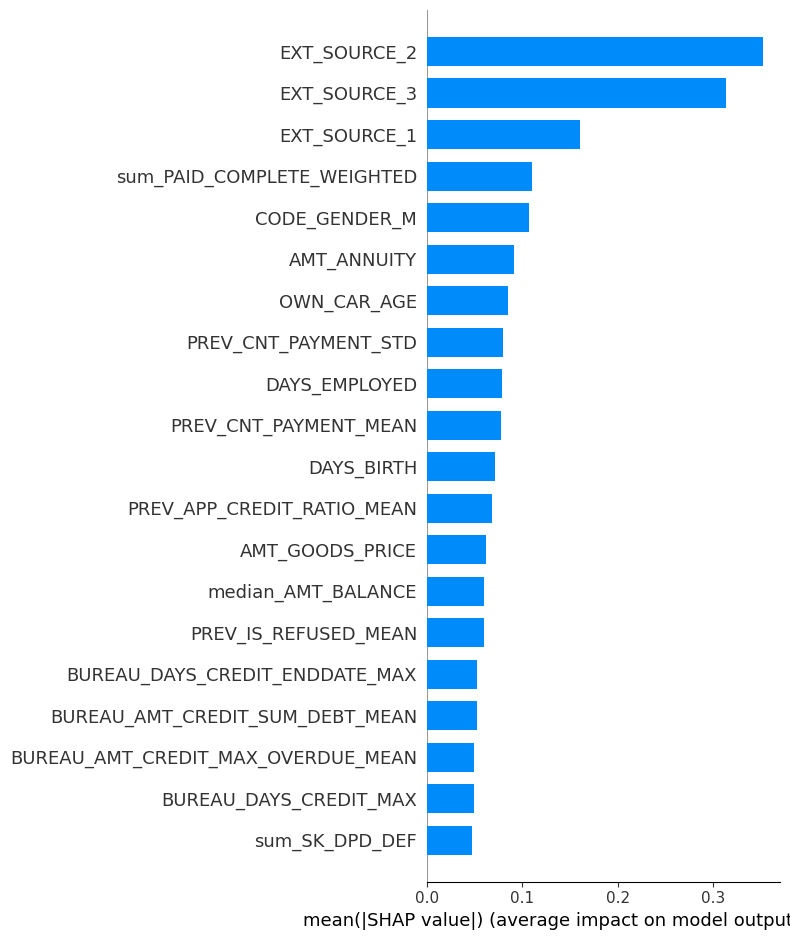

In [ ]:
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Get the underlying LightGBM model from the ExponentiatedGradient mitigator
underlying_model = mitigator.predictors_[0]


# Use sanitized features if necessary
X = X_test3.copy()
y = y_test.copy()

# Create SHAP explainer
explainer = shap.TreeExplainer(underlying_model)
shap_values = explainer.shap_values(X)

# For binary classification: shap_values[1] corresponds to class 1
shap_values_class1 = shap_values[1] if isinstance(shap_values, list) else shap_values

# Calculate mean SHAP value for each feature
mean_shap = pd.Series(np.abs(shap_values_class1).mean(axis=0), index=X.columns)
mean_shap_sorted = mean_shap.sort_values(ascending=False)

# Determine if feature effects are mostly positive or negative
direction = pd.Series(np.sign(shap_values_class1).mean(axis=0), index=X.columns)
direction = direction.map({1: "↑ Increases prediction", -1: "↓ Decreases prediction", 0: "↔ Neutral"})

# Correlation of each feature with the target variable
correlation = X.apply(lambda col: pearsonr(col, y)[0])

# Combine into one summary DataFrame
shap_summary = pd.DataFrame({
    "Mean |SHAP|": mean_shap,
    "Effect Direction": direction,
    "Correlation with Target": correlation
}).sort_values(by="Mean |SHAP|", ascending=False)

# Display top features
top_n = 10
print(shap_summary.head(top_n))

# Plot SHAP summary plot
shap.summary_plot(shap_values_class1, X, plot_type="bar")

In [ ]:
shap_summary.to_csv('model_explanation.csv')